## Open, Plot and Explore Raster Data with Python and Xarray

In [7]:
# Import necessary packages
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Use geopandas for vector data and xarray for raster data
import geopandas as gpd
import rioxarray as rxr

import earthpy as et

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

In [8]:
# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

Extracted output to C:\Users\simon\earth-analytics\data\colorado-flood\.


In [11]:
# Define relative path to file
dem_pre_path = os.path.join("colorado-flood",
                            "spatial",
                            "boulder-leehill-rd",
                            "pre-flood",
                            "lidar",
                            "pre_DTM.tif")

dtm_pre_arr = rxr.open_rasterio(dem_pre_path)
dtm_pre_arr

<xarray.DataArray (band: 1, y: 2000, x: 4000)>
[8000000 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0

In [13]:
# View the coordinate Reference System (CRS) & spatial extent
print("The CRS for this data is:",dtm_pre_arr.rio.crs)
print("The spatial extent is:", dtm_pre_arr.rio.bounds())

The CRS for this data is: EPSG:32613
The spatial extent is: (472000.0, 4434000.0, 476000.0, 4436000.0)


In [14]:
# View no data value
print("The no data value is:", dtm_pre_arr.rio.nodata)

The no data value is: -3.4028235e+38


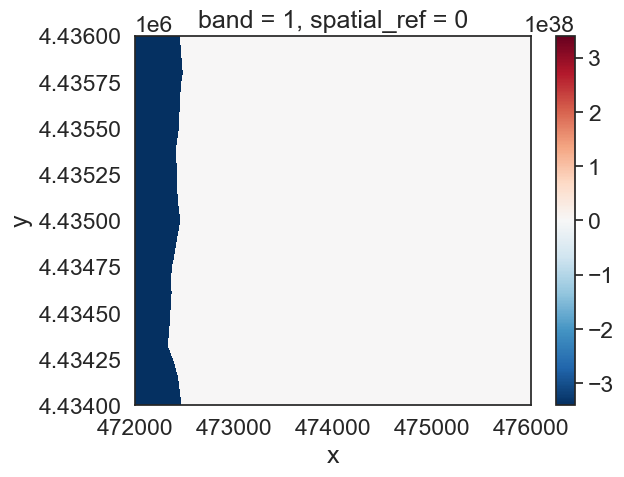

In [15]:
dtm_pre_arr.plot()
plt.show()

The data above should represent terrain model data. However, the range of values is not what is expected. These data are for Boulder, Colorado where the elevation may range from 1000-3000m. There may be some outlier values in the data that may need to be addressed. Below you look at the distribution of pixel values in the data by plotting a histogram. Notice that there seem to be a lot of pixel values in the negative range in that plot.

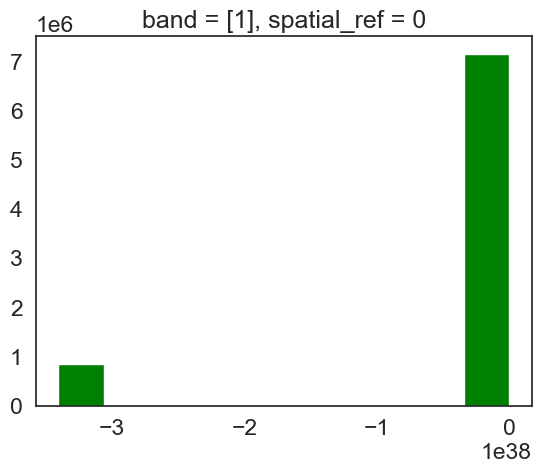

In [17]:
# A histogram can also be helpful to look at the range of values in your data
# What do you notice about the histogram below?
dtm_pre_arr.plot.hist(color="green")
plt.show()

Histogram for your lidar DTM. Notice the number of values that are below 0. This suggests that there may be no data values in the data. Looking at the min and max values of the data, you can see a very small negative number for the minimum. This number matches the nodata value that you looked at above.

In [18]:
print("the minimum raster value is: ", np.nanmin(dtm_pre_arr.values))
print("the maximum raster value is: ", np.nanmax(dtm_pre_arr.values))

the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  2087.43


## Raster Data Exploration - Min and Max Values

Looking at the minimum value of the data, there is one of two things going on that need to be fixed:

    1.there may be no data values in the data with a negative value that are  skewing your plot colors
    2. there also could be outlier data in your raster
    
You can explore the first option - that there are no data values by reading in the data and masking no data values using the `masked=True` parameter like this:

`rxr.open_rasterio(dem_pre_path, masked=True)`

Above you may have also noticed that the array has an additional dimension for the “band”. While the raster only has one layer - there is a 1 in the output of `shape` that could get in the way of processing.

You can remove that additional dimension using `.squeeze()`

In [20]:
# Notice that the shape of this object has a 1 at the beginning
# This can cause issues with plotting
dtm_pre_arr.shape

(1, 2000, 4000)

In [21]:
# Open the data and mask no data values
# Squeeze reduces the third dimension given there is onlyy one "band" or layer to this data
dtm_pre_arr = rxr.open_rasterio(dem_pre_path,masked=True).squeeze()
# Notice there are now only 2 dimensions to array
dtm_pre_arr.shape

(2000, 4000)

## Plot the data again to see what has changed.

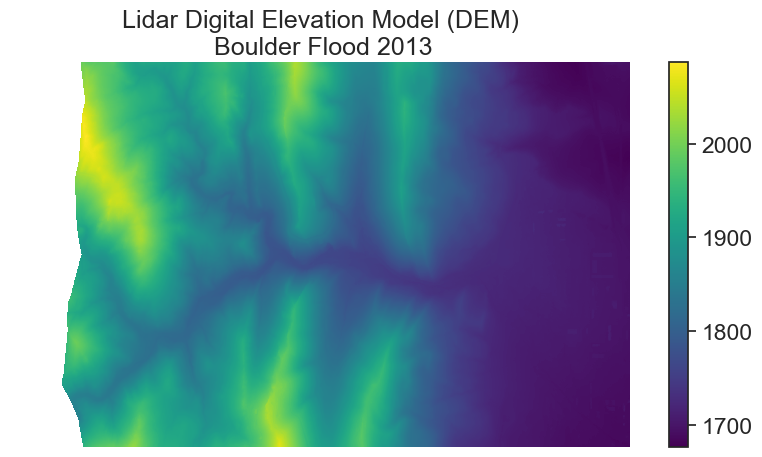

In [23]:
# Plot the data and notice that the scale bar looks beter
# No data values are now masked
f, ax = plt.subplots(figsize=(10,5))
dtm_pre_arr.plot(cmap="viridis",ax=ax)
ax.set_title("Lidar Digital Elevation Model (DEM)\n Boulder Flood 2013")
ax.set_axis_off()
plt.show()

DTM raster plot for Leehill Road in Boulder, Colorado.
The histogram has also changed. Now, it shows a reasonable distribution of pixel values.

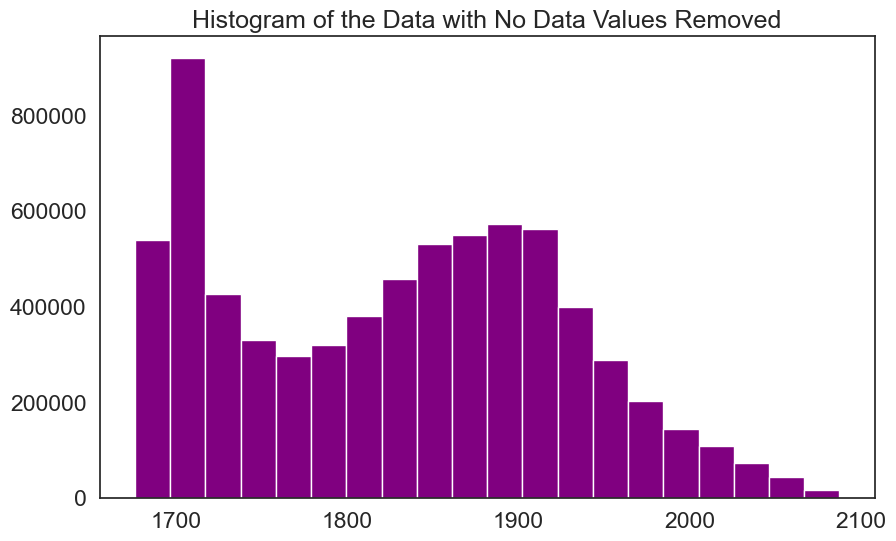

In [30]:
f, ax = plt.subplots(figsize=(10,6))
dtm_pre_arr.plot.hist(color="purple",bins=20)
ax.set_title("Histogram of the Data with No Data Values Removed")
plt.show()

Histogram of DTM Values

Notice that the minimum value looks more like an elevation value (which should most often not be negative)

In [32]:
# Min Max preprocessed data
print("The minimum raster value is: ", np.nanmin(dtm_pre_arr.data))
print("The maximum raster value is: ", np.nanmax(dtm_pre_arr.data))

The minimum raster value is:  1676.21
The maximum raster value is:  2087.43


## Plot Raster and Vector Data Together

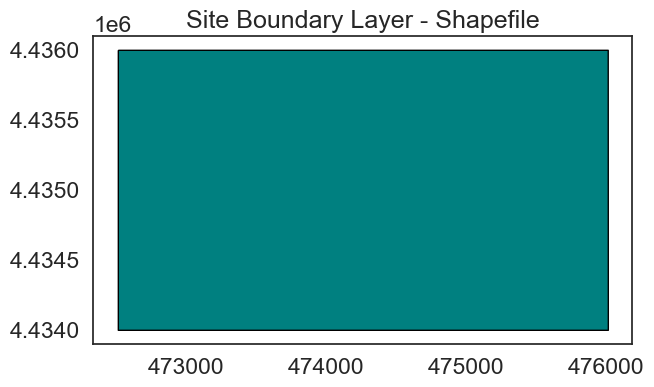

In [33]:
# Open site boundary vector layer
site_bound_path = os.path.join("colorado-flood",
                              "spatial",
                              "boulder-leehill-rd",
                              "clip-extent.shp")
site_bound_shp = gpd.read_file(site_bound_path)

# Plot the vector data
f, ax = plt.subplots(figsize=(8,4))
site_bound_shp.plot(color='teal',
                   edgecolor='black',
                   ax=ax)
ax.set(title="Site Boundary Layer - Shapefile")
plt.show()

Plot of the site boundary using Geopandas.

plot the two datasets together and begin to create a map.

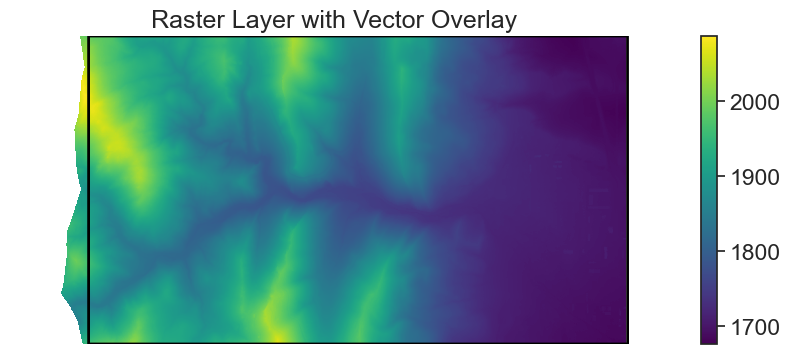

In [35]:
f, ax = plt.subplots(figsize=(11,4))

dtm_pre_arr.plot.imshow(cmap='viridis',
                       ax=ax)

site_bound_shp.plot(color='none',
                   edgecolor='black',
                   linewidth=2,
                   ax=ax,
                   zorder=4)

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
plt.show()

DTM raster layer with a vector study area extent overlayed on top.